###Sentiment Analysis of Movie Reviews

In [0]:
from pyspark.sql.types import (StringType, BooleanType, IntegerType, FloatType, DateType, ArrayType, DoubleType) 
from pyspark.sql.functions import col, udf, array_join, split, shuffle, rand
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.functions import array_to_vector
from pyspark.ml.classification import LogisticRegression, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
from gensim.models import Word2Vec, FastText
import matplotlib.pyplot as plt

In [0]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

Out[49]: True

In [0]:
# File location and type
file_location = "/FileStore/tables/movie_reviews.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [0]:
df.show()

+--------------------+--------------------+--------------------+
|                name|             reviews|             ratings|
+--------------------+--------------------+--------------------+
|      21 Jump Street|I thoroughly enjo...|                 4.5|
|      21 Jump Street|A great work of c...|                 4.0|
|      21 Jump Street|Infantile. Cringe...|                 0.5|
|      21 Jump Street|A classic in mode...|                 5.0|
|      21 Jump Street|LOL, the funniest...|                 5.0|
|      21 Jump Street|Absolutely hilari...|                 5.0|
|      21 Jump Street|Absolutely hilari...|                 4.5|
|      21 Jump Street|Great self-aware ...|                 4.0|
|      21 Jump Street|Wasn't sure how a...|                null|
|One of 2012's bes...|                 4.0|                null|
|      21 Jump Street|Very funny movie,...|                 4.5|
|      21 Jump Street|Instant classic. ...|                 4.0|
|      21 Jump Street|"Su

In [0]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- reviews: string (nullable = true)
 |-- ratings: string (nullable = true)



In [0]:
df.count()

#### Data Cleaning

In [0]:
df = df.withColumn('cleaned_rating', df['ratings'].cast("double")).drop('ratings')
df = df.filter( (df.cleaned_rating.isNotNull()) & (df.cleaned_rating<5.1) & (df.cleaned_rating>-0.1) )
df = df.select(df.reviews, df.cleaned_rating)
df.count()

Out[51]: 1271

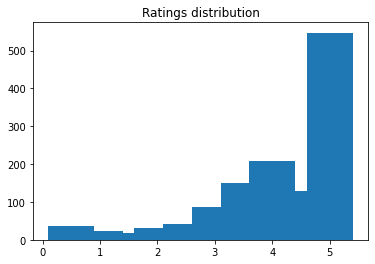

In [0]:
rating_count = df.groupBy("cleaned_rating").count().orderBy('cleaned_rating')
plt.bar(rating_count.rdd.map(lambda x:x['cleaned_rating']).collect(), rating_count.rdd.map(lambda x:x['count']).collect())
plt.title("Ratings distribution",)
plt.show()

In [0]:
@udf
def lower_clean_str(x):
  punc='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
  lowercased_str = x.lower()
  for ch in punc:
    lowercased_str = lowercased_str.replace(ch, '')
  return lowercased_str

df = df.withColumn('cleaned_review', lower_clean_str(df["reviews"])).drop('reviews')

#### Calculate Sentiment Score and Assign Label

In [0]:
# Create sentiment score

analyzer = SentimentIntensityAnalyzer()
@udf
def fake_review(text, ratings):
    scores = analyzer.polarity_scores(text)
    if scores['pos'] > 0 and ratings<4:
        return 1
    elif scores['pos'] < 0 and ratings>=4:
        return 1
    return 0

df = df.withColumn('fake_review', fake_review(df["cleaned_review"], df['cleaned_rating']))
df = df.withColumn('fake_review',df['fake_review'].cast('int'))
df.show()

+--------------+--------------------+-----------+
|cleaned_rating|      cleaned_review|fake_review|
+--------------+--------------------+-----------+
|           4.5|i thoroughly enjo...|          0|
|           4.0|a great work of c...|          0|
|           0.5|infantile cringew...|          0|
|           5.0|a classic in mode...|          0|
|           5.0|lol the funniest ...|          0|
|           5.0|absolutely hilari...|          0|
|           4.5|absolutely hilari...|          0|
|           4.0|great selfaware a...|          0|
|           4.5|very funny movie ...|          0|
|           4.0|instant classic i...|          0|
|           5.0|lol the funniest ...|          0|
|           0.5|they changed my b...|          0|
|           5.0|best movie of tgu...|          0|
|           5.0|thank you jonah f...|          0|
|           5.0|amazing movie fan...|          0|
|           3.5|2nd watch 67 defi...|          1|
|           3.5|21 jump street is...|          1|


In [0]:
df.printSchema()

In [0]:
rating_count = df.groupBy("fake_review").count().orderBy('fake_review')
plt.figure(figsize =(4, 4))
plt.bar(rating_count.rdd.map(lambda x:x['fake_review']).collect(), rating_count.rdd.map(lambda x:x['count']).collect())
plt.title("Ratings distribution",)
plt.ylabel('Count')
plt.xlabel('Fake Review')
plt.xticks(rating_count.rdd.map(lambda x:x['fake_review']).collect(), labels=['False', 'True'])

plt.show()

In [0]:
df.filter(df['fake_review']==1).count()/df.count()

#### Text Preprocessing
1. Tokenize
2. Lemmatize
3. Remove Stopwords

In [0]:
# Tokenize
tokenizer = Tokenizer(inputCol="cleaned_review", outputCol="tokens")
df = tokenizer.transform(df)

In [0]:
# Lemmatize
lemmatizer = WordNetLemmatizer()
@udf
def lemmatize_tokens(tokens):
    lemmatized_tokens = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_tokens

df = df.withColumn('lemmatized_tokens', lemmatize_tokens(df["tokens"]))
tokenizer2 = Tokenizer(inputCol="lemmatized_tokens", outputCol="lemmatized_tokens_array")
df = tokenizer2.transform(df)

In [0]:
# remove stopwords

stop = StopWordsRemover.loadDefaultStopWords("english")
remover = StopWordsRemover(stopWords=stop, inputCol="lemmatized_tokens_array", outputCol="clean_review")

df = remover.transform(df)

In [0]:
df.show()

####Embedding Word2Vec

In [0]:
# Convert PySpark DataFrame to a Gensim-friendly format
documents = df.rdd.map(lambda r: r["clean_review"]).collect()

# Train a Gensim Word2Vec model
model = FastText(sentences=documents, vector_size=100, window=5, min_count=1, sg=1)

In [0]:
embedded_vectors = []

for row in df.select('clean_review').collect():
    embedded_vectors.append(model.wv[row.clean_review].sum(axis=0))

embedded_vectors

Out[58]: [array([-15.468523  ,   3.3523204 ,  -3.8834555 ,   7.754147  ,
         15.160472  ,  14.507773  ,  -0.57607996,  35.92083   ,
         27.541578  , -20.562431  ,   0.803238  ,   5.1789794 ,
        -21.215874  ,  22.333904  ,  17.006023  ,  10.518144  ,
         -0.07885373,   1.1266794 , -19.616869  , -27.467365  ,
        -17.14144   ,   5.0270753 ,  -4.6437454 , -17.412565  ,
        -12.274587  ,  -3.8198893 ,   1.6914004 ,   2.7450807 ,
         16.395975  ,  -6.4902    ,  -5.8521867 ,  -0.31160137,
          9.325584  ,  -3.3206189 , -13.109565  ,  17.582958  ,
         11.820335  ,  21.287367  , -12.722846  ,  -7.301315  ,
         12.867511  , -13.6312    ,  -2.4422665 , -16.992687  ,
         -7.3470283 ,  -2.8870554 ,  -2.6297212 , -14.137699  ,
         -0.7639425 ,   1.7270086 ,  18.846172  ,  -4.676466  ,
          4.1811337 ,  -0.13359001,  -4.482543  , -22.625214  ,
         -8.828624  ,   5.7995014 ,  -8.302737  ,   1.0225881 ,
          9.006466  , -20.72876

#### Oversampling

In [0]:
oversample = SMOTE()
X, y = oversample.fit_resample(np.array(embedded_vectors), np.array(df.select("fake_review").collect()))

df = spark.createDataFrame(pd.DataFrame({'array_reviews':X.tolist(), 'fake_review':y}))
df = df.withColumn('vector_reviews', array_to_vector(df['array_reviews']))

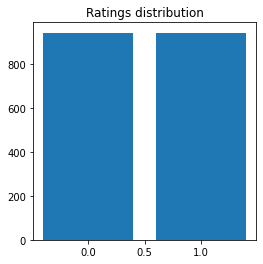

In [0]:
rating_count = df.groupBy("fake_review").count().orderBy('fake_review')
plt.figure(figsize =(4, 4))
plt.bar(rating_count.rdd.map(lambda x:x['fake_review']).collect(), rating_count.rdd.map(lambda x:x['count']).collect())
plt.title("Ratings distribution",)
plt.show()

In [0]:
df.count()

Out[13]: 1888

In [0]:
train, test = df.randomSplit(weights=[0.8,0.2], seed=200)
train = train.select("*").orderBy(rand())
test = test.select("*").orderBy(rand())

#### Split into Train and Test datasets and Shuffle

In [0]:
train.filter(train['fake_review']==1).count()/train.count()

Out[31]: 0.49933774834437084

In [0]:
test.filter(test['fake_review']==1).count()/test.count()

In [0]:
train.printSchema()

### Models

##### Logistic Regression

In [0]:
#Train model

log_reg = LogisticRegression(featuresCol='vector_reviews', labelCol='fake_review')
log_reg = log_reg.fit(train)
res = log_reg.transform(train)
res.filter(res.fake_review == res.prediction).count()/res.count() ## Train Accuracy

Out[61]: 0.6543046357615894

In [0]:
## Test Accuracy
res = log_reg.transform(test)
res.filter(res.fake_review == res.prediction).count()/res.count() 

Out[62]: 0.6825396825396826

##### Linear SVM

In [0]:
# Train model

lsvc = LinearSVC(featuresCol='vector_reviews', labelCol="fake_review", maxIter=50)
lsvc = lsvc.fit(train)
res = lsvc.transform(train)
res.filter(res.fake_review == res.prediction).count()/res.count() ## Train Accuracy

Out[34]: 0.6589403973509934

In [0]:
## Test Accuracy
res = lsvc.transform(test)
res.filter(res.fake_review == res.prediction).count()/res.count() 

Out[35]: 0.6534391534391535

##### Decision Tree

In [0]:
#Train model

dtc = DecisionTreeClassifier(featuresCol='vector_reviews', labelCol="fake_review")
dtc = dtc.fit(train)
res = dtc.transform(train)
res.filter(res.fake_review == res.prediction).count()/res.count() ## Train Accuracy

Out[36]: 0.7245033112582782

In [0]:
## Test Accuracy
res = dtc.transform(test)
res.filter(res.fake_review == res.prediction).count()/res.count() 

Out[37]: 0.701058201058201

##### Random Forest

In [0]:
#Train model

rfc = RandomForestClassifier(featuresCol='vector_reviews', labelCol="fake_review", numTrees=10)
rfc = rfc.fit(train)
res = rfc.transform(train)
res.filter(res.fake_review == res.prediction).count()/res.count() ## Train Accuracy

Out[38]: 0.7225165562913908

In [0]:
## Test Accuracy
res = rfc.transform(test)
res.filter(res.fake_review == res.prediction).count()/res.count() 

Out[39]: 0.6851851851851852

##### Gradient Boost

In [0]:
#Train model

gbtc = GBTClassifier(featuresCol='vector_reviews', labelCol="fake_review", maxIter=10)
gbtc = gbtc.fit(train)
res = gbtc.transform(train)
res.filter(res.fake_review == res.prediction).count()/res.count() ## Train Accuracy

Out[40]: 0.828476821192053

In [0]:
## Test Accuracy
res = gbtc.transform(test)
res.filter(res.fake_review == res.prediction).count()/res.count() 

Out[41]: 0.7222222222222222

##### Multilayer Perceptron

In [0]:
#Train model 

layers = [100, 64, 32, 8, 2]

mlpc = MultilayerPerceptronClassifier(featuresCol='vector_reviews', labelCol="fake_review", maxIter=1000, layers=layers, blockSize=128, seed=132)
mlpc = mlpc.fit(train)
res = mlpc.transform(train)
res.filter(res.fake_review == res.prediction).count()/res.count() ## Train Accuracy

Out[42]: 0.8509933774834437

In [0]:
## Test Accuracy
res = mlpc.transform(test)
res.filter(res.fake_review == res.prediction).count()/res.count() 

Out[43]: 0.7645502645502645